# Introduction

#_Brief Introduction to the project and its goals._#

# Setting up the Environment

### Importing Libraries

In [1]:
from dateutil import relativedelta

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Mike: Training Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Mike: Maths tools for CV param grids
from scipy.stats import uniform, truncnorm, randint


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix


### Notebook Display Settings


In [2]:
# Change the maximum number of rows displayed when viewing the pandas dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import os
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Default Figure Settings

In [3]:
# Set plot properties
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)

# Choose the font for the plots based on os (as some fonts are not available across different os)
if os.name=='nt':
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['font.sans-serif'] = "Arial"
elif os.name=='posix':  
    mpl.rcParams['font.family'] = "Mukti Narrow"

# Enables colour codes for seaborn plots
sns.set(color_codes=True)

### Parallel Processing Configuration

In [4]:
import multiprocessing as mp

# Get the number of cpu available for parallel processing
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

## Read the Data

In [5]:
# Read the csv file 
data=pd.read_csv('Data/epl-training.csv')

# Dropping the trailing columns
data.dropna(axis=1, how='all',inplace=True)

# data['Date']=pd.to_datetime(data['Date'], format='%d/%m/%Y') #Mike: The new fmt causes some malfunctions
pd_dt_array = pd.to_datetime(data['Date'], format='%d/%m/%Y') #I haven't seen the neccessity for it, so I made a new array for it

data.drop([column for column in data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
print("Shape of the table (rows, columns): ", data.shape)
data.dtypes

Shape of the table (rows, columns):  (4180, 22)


Date        object
HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
FTR         object
HTHG         int64
HTAG         int64
HTR         object
Referee     object
HS           int64
AS           int64
HST          int64
AST          int64
HF           int64
AF           int64
HC           int64
AC           int64
HY           int64
AY           int64
HR           int64
AR           int64
dtype: object

In [6]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


## Exploratory Data Analysis

### Check if there are duplicate or null value data.

In [7]:
print("Number of duplicate rows: ", data[data.duplicated()].shape[0])
print("Number of null blocks by colums:\n", data.isnull().sum(), sep='') #TODO: consider to plot it instead

Number of duplicate rows:  0
Number of null blocks by colums:
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


As suggested by the output, we don't need to deal with null data nor duplicate rows in this dataset.

### Function definitions

The function __get_pivot_column_vs_column_count__ returns a dataframe after pivoting a column against another column. The elements of dataframe represent counts of all the different combinations of __col1__ and __col2__ in the dataframe __df__.

In [8]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

The function __get_column_countplot__ plots a bar chart. The bar chart is representative of the column __col__ in the dataframe __df__. The function counts the occurances of each value taken by __col__ in combination with the different outcome of __FTR__ (i.e. H, D, A). 

In [9]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

### Number of teams

#### Number of unique teams in the table:

In [10]:
data['HomeTeam'].nunique()

36

#### Checking if all the team in the column `HomeTeam` are in `AwayTeam`

In [11]:
np.array_equal(sorted(data['HomeTeam'].unique()),sorted(data['AwayTeam'].unique()))

True

#### List of all teams in the data:

In [12]:
print(sorted(data['HomeTeam'].unique()))

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


### Analysing the `Referee` column

#### The number of unique referees in dataset:

In [13]:
data['Referee'].nunique()

36

> It can be seen that the number of referees here is the same as the number of teams

In [14]:
data['Referee'].nunique()==data['HomeTeam'].nunique()

True

### Analysing the Dates

The first and the last date (when arranged chronologically) observed in the table:

In [15]:
print("The earliest date in the table: ", pd_dt_array.min())
print("The latest date in the table: ", pd_dt_array.max())

The earliest date in the table:  2008-08-16 00:00:00
The latest date in the table:  2019-05-12 00:00:00


In [16]:
rd = relativedelta.relativedelta(pd_dt_array.max(),pd_dt_array.min())
print('%d years %d months %d days'%(rd.years,rd.months,rd.days))

10 years 8 months 26 days


In [17]:
sorted((pd_dt_array.dt.month).unique())

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12]

It can be seen here that 6 and 7 are missing.

> This means that no matches happen in June and July.

Therefore, we can consider that: 

> Each Season starts from __August to May__ and so we can deduce that the data covers __11 Seasons__

### Number of Matches played by the teams

A count of the occurances of each combination of Home and Away team allocation.

In [18]:
get_pivot_column_vs_column_count(data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,8.0,2.0,4.0,1.0,4.0,4.0,2.0,5.0,2.0,11.0,6.0,11.0,7.0,2.0,5.0,5.0,11.0,11.0,11.0,2.0,9.0,4.0,2.0,3.0,1.0,7.0,10.0,9.0,7.0,11.0,4.0,9.0,10.0,5.0,4.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,1.0,NaN,2.0,1.0,8.0,3.0,8.0,6.0,NaN,4.0,2.0,8.0,8.0,8.0,1.0,7.0,4.0,2.0,3.0,1.0,4.0,8.0,8.0,5.0,8.0,1.0,7.0,7.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,4.0,4.0,4.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,4.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,NaN,1.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,NaN,1.0
Burnley,5.0,2.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,5.0,4.0,5.0,2.0,2.0,3.0,4.0,5.0,5.0,5.0,1.0,3.0,NaN,1.0,1.0,NaN,4.0,4.0,3.0,3.0,5.0,3.0,3.0,5.0,1.0,2.0


Checking how many matches each team played. As every match a home team plays at home comes in conjunction with one it plays away, it is sufficient to count the number of home matches. 

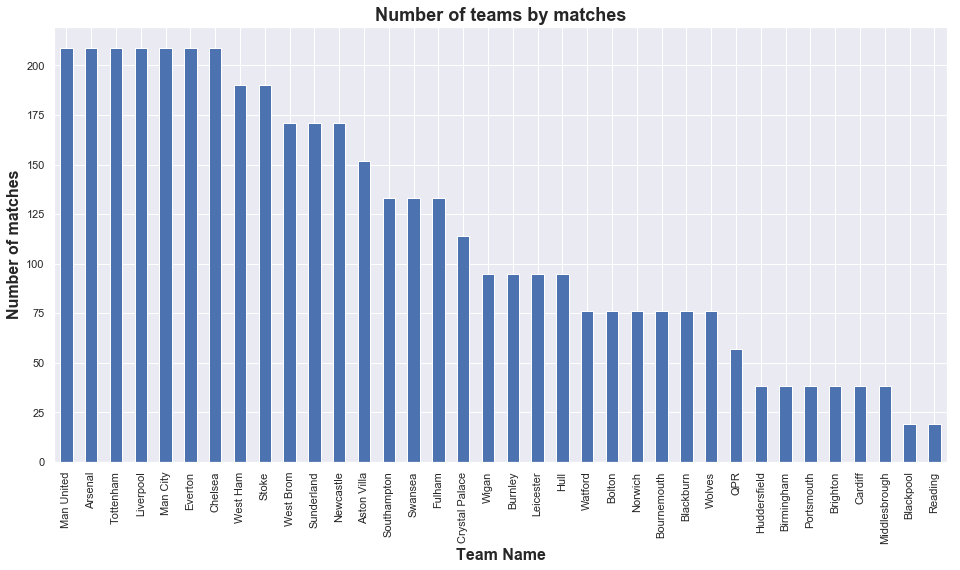

In [19]:
data.AwayTeam.value_counts().plot(kind='bar', figsize=(16,8))
plt.title('Number of teams by matches',fontsize=18, fontweight='bold')
plt.ylabel('Number of matches',fontsize=16, fontweight='bold')
plt.xlabel('Team Name',fontsize=16, fontweight='bold')
sns.set_style("white")
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

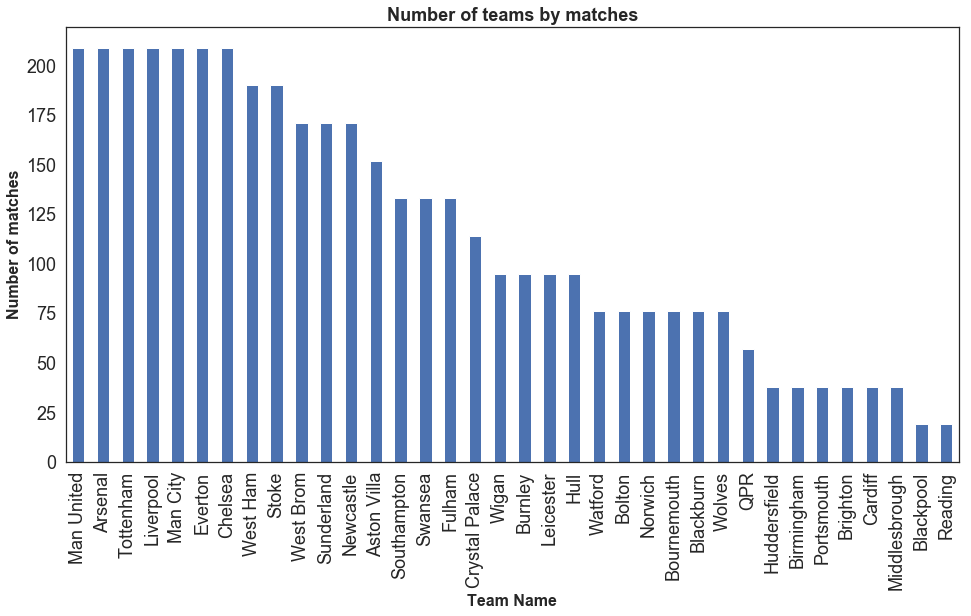

In [20]:
data.HomeTeam.value_counts().plot(kind='bar', figsize=(16,8))
plt.title('Number of teams by matches',fontsize=18, fontweight='bold')
plt.ylabel('Number of matches',fontsize=16, fontweight='bold')
plt.xlabel('Team Name',fontsize=16, fontweight='bold')
sns.set_style("white")
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

### HTR vs. FTR

A count plot to show the relationship between Half Time Result (`HTR`) and Full Time Result (`FTR`). This was done basically to check for how many of the matches the `HTR` and `FTR` result.

In [21]:
get_pivot_column_vs_column_count(data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,703,199,99
D,439,647,646
H,70,191,1186


###  Histogram (Count Plots) of all Features

The columns of the unprocessed dataset will later be used to extract information about the individual teams. To investigate the characteristics of each of the individual columns, we first utilize a histogram plot of each of the columns. Prior to obtaining this plot, all the categorical columns (Home Team, Away Team, Referee and Full Time Result) are turned into numerical values using the __Label_Encoder__ function.

Bar Chart for each of the numerical features in the imported dataset. The bar chart will show a count of the occurances of each unique value taken by each feautre. In addition to this, the bar chart will show what proportion of each unique value that resulted in Home win (__H__), Draw (__D__) or Away win (__A__).

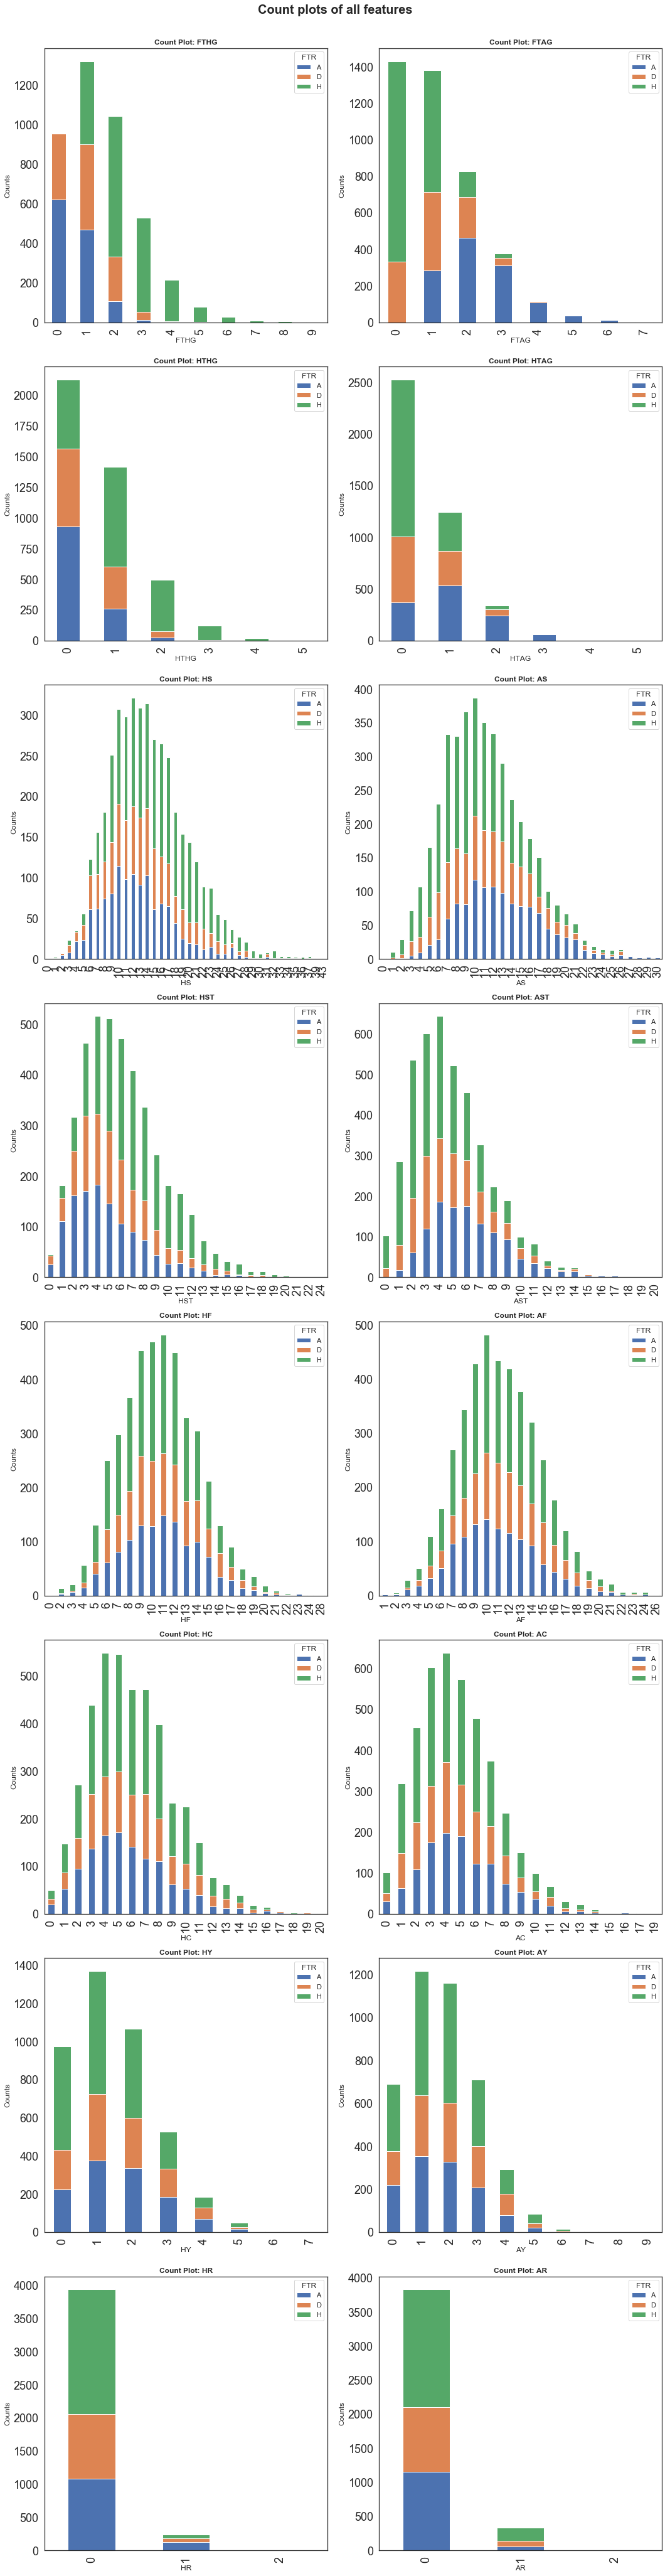

In [22]:
# Save the column names of numerical features as a list
num_col_list=[x for x in data.columns if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]

# Reshaping array for easier formatting
num_col_list = np.reshape(num_col_list, (8, 2))

# Call the function get_column_countplot() to plot the count plot of the categorical columns as s ubplots in a figure
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i in range(8):
    for j in range(2):
        get_column_countplot(data,num_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
sns.set_style("white")
plt.show()

### Checking if the dataset is balanced

A bar chart showing the number of home wins, draws and away wins.

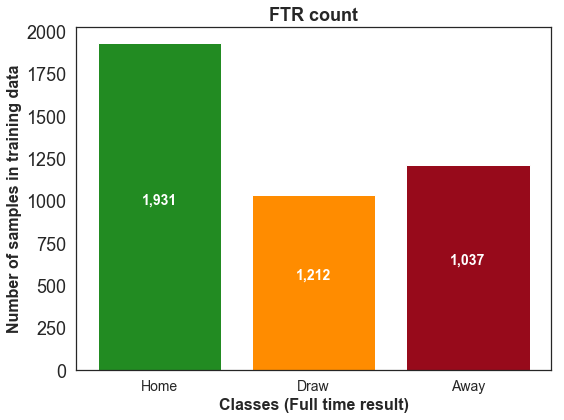

In [23]:
# Get the counts 
count_val=data['FTR'].value_counts()

# Visualise the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom', fontweight='bold', fontsize=14)
ax.set_title('FTR count', fontsize=18, fontweight='bold')
ax.set_xlabel('Classes (Full time result)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of samples in training data', fontsize=16, fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
sns.set_style("white")
plt.show()

#### Encoding the non-numerical columns

In [24]:
encoded_data = data.copy()

for column in ['HomeTeam','AwayTeam','Referee','FTR','HTR']:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])

### Correlation Matrix of the Raw Data

A visual plot of the correlation matrix between the all the raw columns of the provided dataset. This will help identify important columns as well as discard those that show no correlation. For this, the label encoded dataset will be utilized.

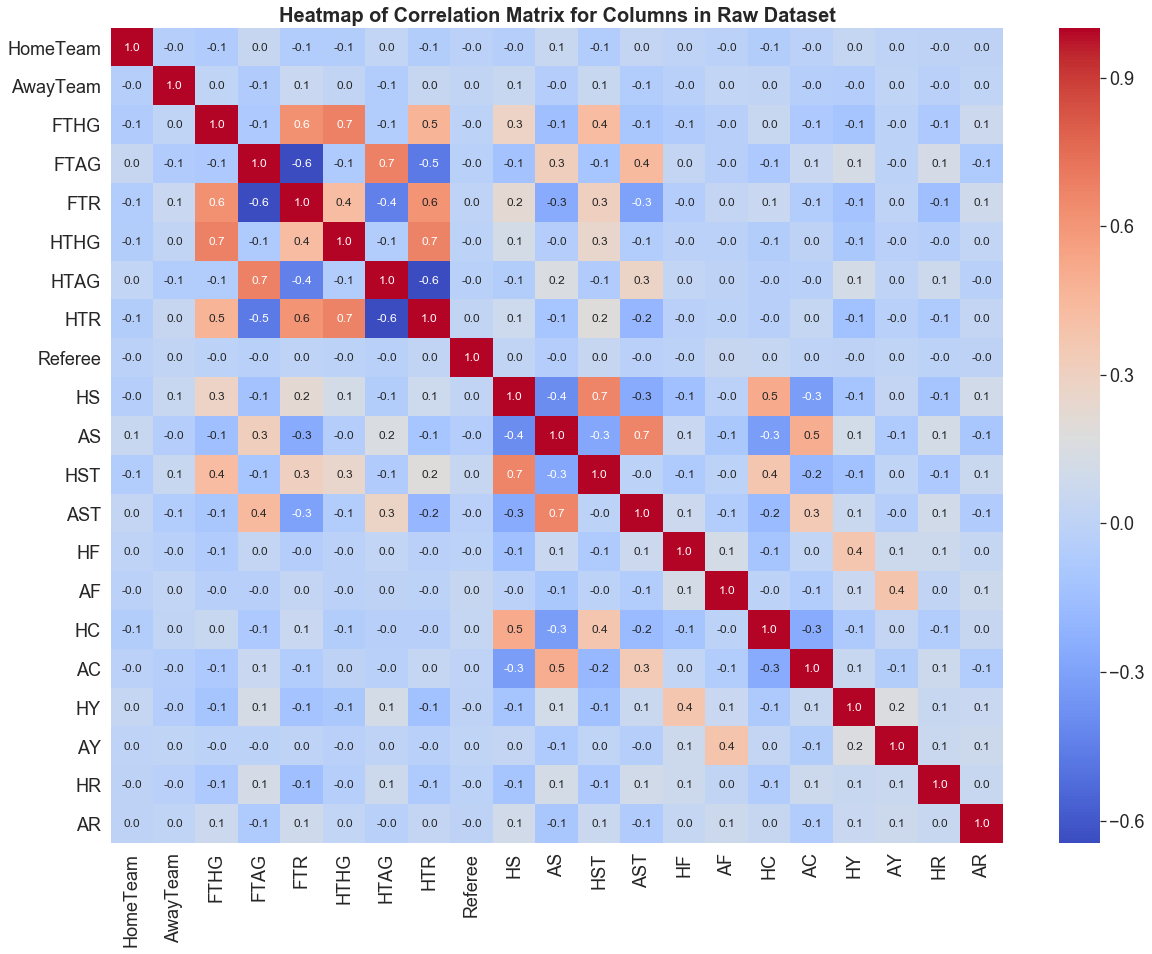

In [25]:
fig=plt.figure(figsize=(20,15))
ax = plt.subplot()
ax.set_title("Heatmap of Correlation Matrix for Columns in Raw Dataset",fontsize=20,fontweight='bold')
sns.heatmap(encoded_data.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)
plt.show()

### Mean, Percentiles and Trimming of Data

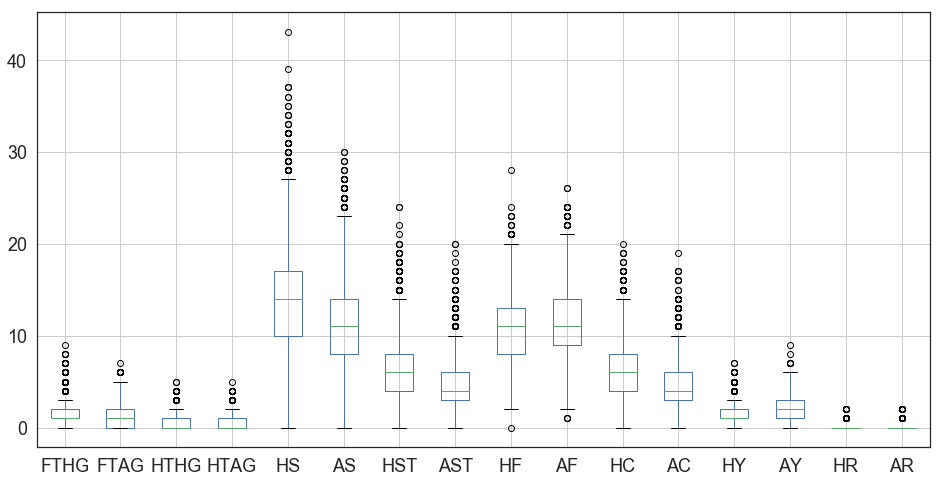

In [26]:
data.boxplot(figsize=(16,8));

We can see that there are considerable amount of outliers for some features. This can be caused by such as very strong team scores a lot against a very weak team. These kinds of outliers can introduce bias, which influence out prediction performance.

Let's implement a function to trim it.

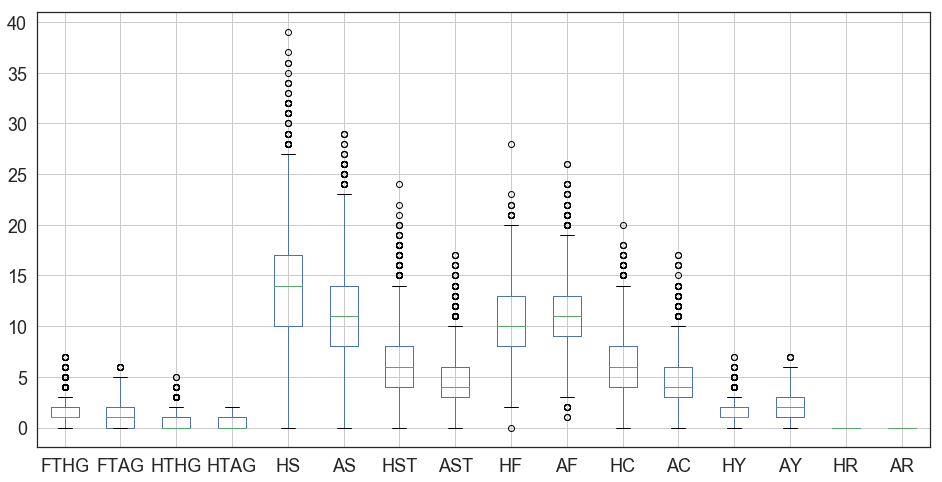

In [27]:
def trim_data(data, q1 = 0.25, q2 = 0.75):
    Q1 = data.quantile(q1); Q3 = data.quantile(q2);
    IQR = Q3 - Q1
    data_trimmed = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data_trimmed

q1 = 0.1
q2 = 0.9
data_trimmed = trim_data(data, q1, q2)
data_trimmed.boxplot(figsize=(16,8));

We set the quantile range of 0.2 ~ 0.8 in this case. Cause trimming causes loss of valuable data. From the above figure, we can indeed see the outliers are reduced.

Let's see how much data was lost by setting this threshold range.

In [28]:
rows_org = int(data.shape[0])
rows_trimmed = int(data_trimmed.shape[0])
loss = rows_org - rows_trimmed

print('Loss of data:{} Percentage:{:.1f}%'.format(loss, 100 * loss/rows_org),
      '\nOld Data Numbers:', rows_org,
      '\nNew Data Numbers:', rows_trimmed
     )

#M: disable comments for conducting data trimming experiment.
data= data_trimmed
data = data.reset_index()

Loss of data:634 Percentage:15.2% 
Old Data Numbers: 4180 
New Data Numbers: 3546


Thus, there is a trade-off here. Let's keep the original data for now, and compare if trimming can improve perfomance after we train the original data.

# Feature Extraction

### Average Goals, Points and Aggressiveness

Calculating average goals and scores for home teams and away teams. The scores are calculated by considering a win as 3 points, a draw as 1 point and a loss as 0 points. As the number of goals conceded by one team is the number of goals scored by the other team, the average number of goals conceded by the home team is equal to the number of goals scored by the away team (the same applies for goals conceded by the away team). These average values will be used to scale metrics later on in feature extraction to ensure that a value of 1 represents an average performance. This will ensure that the features are of similar scale. 

In [29]:
# Get total number of matches
num_matches = data.shape[0] 

# Sum home goals column, divide by total matches
average_home_goals = data.FTHG.sum()/num_matches

# Sum away goals column, divide by total matches
average_away_goals = data.FTAG.sum() /num_matches

# Average conceded goals = Average of goals for opposite team
avg_home_conceded = average_away_goals 
avg_away_conceded = avg_home_conceded

# Calculating points for each team
average_home_points = (3*count_val['H'] + count_val['D'])/num_matches
average_away_points = (3*count_val['A'] + count_val['D'])/num_matches

# Calculating other average  home and away
average_home_yellow = data.HY.sum()/num_matches
average_away_yellow = data.AY.sum()/num_matches
average_home_red = data.HR.sum()/num_matches
average_away_red = data.AR.sum()/num_matches
average_home_fouls = data.HF.sum()/num_matches
average_away_fouls = data.AF.sum()/num_matches

print('Average Home Goals:', average_home_goals)
print('Average Away Goals:', average_away_goals)
print('Average Home Points:',average_home_points)
print('Average Away Points:', average_away_points)
# print('Average Home Yellow Cards:', average_home_yellow)
# print('Average Away Yellow Cards:', average_away_yellow)
# print('Average Home Red Cards:',average_home_red)
# print('Average Away Red Cards:', average_away_red)
print('Average Home Fouls:',average_home_fouls)
print('Average Away Fouls:', average_away_fouls)

Average Home Goals: 1.5532994923857868
Average Away Goals: 1.1125211505922166
Average Home Points: 1.9261139311900732
Average Away Points: 1.3178228990411731
Average Home Fouls: 10.594472645234067
Average Away Fouls: 11.126621545403271


### Team Statistics

Features in the raw data may be used to compute metrics that quantify different qualities of each team when they are playing at home and away. These quantities will be the same for all the home/away matches they play (i.e. a team will have the same Home Attacking Strength (HAS) for all games that it plays on home turf).

In [30]:
team_stats= pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS','HS','HST','AS','AST','HCON','ACON','HF','AF','HAGG','AAGG'))

In [31]:
# Group data by the teams
res_home = data.groupby('HomeTeam')
res_away = data.groupby('AwayTeam')

In [32]:
# Add the list of team names
team_stats.Team = pd.Series(data['HomeTeam'].unique())

In [33]:
# Home goal scored (HGS)
team_stats.HGS = res_home.FTHG.sum().values 
# Home goal conceded (HGC)
team_stats.HGC = res_home.FTAG.sum().values

In [34]:
# Away goal scored (AGS)
team_stats.AGS = res_away.FTAG.sum().values 
# Away goal conceded (AGC)
team_stats.AGC = res_away.FTHG.sum().values 

In [35]:
# Calculate number of games played
total_home_games_played = res_home.FTHG.count()
total_away_games_played = res_away.FTAG.count()

In [36]:
# Home Attacking Strength
team_stats.HAS = (np.divide(team_stats.HGS,total_home_games_played.values)) / average_home_goals
# Away Attacking Strength
team_stats.AAS = (np.divide(team_stats.AGS,total_away_games_played.values)) / average_away_goals

In [37]:
# Home Defensive Strength
team_stats.HDS = (np.divide(team_stats.HGC,total_home_games_played.values)) / avg_home_conceded
# Away Defensive Strength
team_stats.ADS = (np.divide(team_stats.AGC,total_away_games_played.values)) / avg_away_conceded

In [38]:
# Obtaining for each team: Average number of goals scored and conceded when at home and at away.
team_stats.GSA = (np.divide(team_stats.AGS,total_away_games_played.values))
team_stats.GSH = (np.divide(team_stats.HGS,total_home_games_played.values))

team_stats.GCA = (np.divide(team_stats.AGC,total_away_games_played.values))
team_stats.GCH = (np.divide(team_stats.HGC,total_home_games_played.values))

In [39]:
# Shots taken at home and away
team_stats.HS = res_home.HS.sum().values 
team_stats.AS = res_away.AS.sum().values

# Shots taken on target at home and away
team_stats.HST = res_home.HST.sum().values 
team_stats.AST = res_away.AST.sum().values

# Shot conversion rate (accuracy) at home and away
team_stats.HCON = (np.divide(team_stats.HST,team_stats.HS)) 
team_stats.ACON = (np.divide(team_stats.AST,team_stats.AS)) 

In [40]:
# Total number of fouls at home and away
team_stats.HF = res_home.HF.sum().values 
team_stats.AF = res_away.AF.sum().values

# A measure of aggressiveness for each team
team_stats.HAGG = (np.divide(team_stats.HF,total_home_games_played.values)) / average_home_fouls
team_stats.AAGG = (np.divide(team_stats.AF,total_away_games_played.values)) / average_away_fouls

In [41]:
team_stats.head()

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS,HS,HST,AS,AST,HCON,ACON,HF,AF,HAGG,AAGG
0,Arsenal,368,260,1.353800,1.442614,137,220,0.703678,1.220673,2859,1341,2082,953,0.469045,0.457733,1772,1618,0.955754,0.897636
1,Bolton,149,132,0.761308,0.892101,161,231,1.148542,1.561177,1516,687,1303,612,0.453166,0.469685,1359,1590,1.018051,1.074440
2,Everton,35,31,0.704146,0.819548,33,62,0.926949,1.639096,321,159,288,171,0.495327,0.593750,331,369,0.976335,0.975403
3,Hull,79,60,0.770598,0.869864,82,130,1.116765,1.884705,819,430,562,311,0.525031,0.553381,831,762,1.188441,1.104587
4,Middlesbrough,26,21,1.046160,1.179753,32,31,1.797719,1.741540,205,113,179,92,0.551220,0.513966,178,163,1.050076,0.915597


Not all the features in the table above will be used in the final input features of the classifier. Some of these statistics are intermediate values which aided in the calculation of other statistics. For example the __HGS__ column was used to compute the __HAS__ column. 

### Calculation of Form

Form is a calculation of a team's recent performance. Additionally these statistics vary with different allocations. (i.e. a team may have different __FFPTSH__ for different matches played at home). The function __get_features_match__ takes a match info and number of matches as inputs. The function then finds the number of past matches where the two teams played each other. If __n__ or more such matches exist, then the function computes 3 quantities: __FFPTSH__: Average points of home team in the past n matches against the away team, __FFHG__: Average goals of away team against home team in past n matches and __FFAG__: Average goals of home team against away team in the past n matches. If no matches are found then, the average quantities for these statistics are used. 

In [42]:
def get_features_match(match, n=5):
    team1 = match['HomeTeam']
    team2 = match['AwayTeam']
    # Constructing a table when all the matches between the two teams are shown.
    res = data[((data['HomeTeam']==team1) & (data['AwayTeam']==team2)) | ((data['AwayTeam']==team1) & (data['HomeTeam']==team2))]
    name = match.name
    idx = res.index.get_loc(name)
    if idx >= n: #If there is at least n matches between the teams
        matches = res.iloc[idx-n:idx]
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if row['FTR'] == 'H':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if row['FTR'] == 'A':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
        pts_avg = pts_home/n
        goals_home_avg = goals_home/n
        goals_away_avg = goals_away/n
    elif idx == 0: # If there is 0 matches between the teams
        pts_avg = average_home_points
        goals_home_avg = average_home_goals
        goals_away_avg = average_away_goals
    else: #Some games between the teams but not n
        matches = res.iloc[0:idx]
        m = len(matches)
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if row['FTR'] == 'H':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if row['FTR'] == 'A':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
        pts_avg = pts_home/m
        goals_home_avg = goals_home/m
        goals_away_avg = goals_away/m
    return pts_avg, goals_home_avg, goals_away_avg


Another measure of form is the winning streak of the team. The fucntion __get_features_streak_home__ takes match info and the number of matches to consider as the inputs. It computes three quantities: __PSH__ the point streak of the home team, __SSH__ the average goals over the past __n__ games for the home team and __CSH__ the average goals conceded over the past __n__ matches for the home team. A similar function called __get_features_streak_away__ does the same for the away team. 

In [43]:
def get_features_streak_home(match, n=15):
    team1 = match['HomeTeam']
    team1_stats = data[((data['HomeTeam']==team1) | (data['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if row['FTR'] == 'H':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if row['FTR'] == 'A':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

In [44]:
def get_features_streak_away(match, n=15):
    team1 = match['AwayTeam']
    team1_stats = data[((data['HomeTeam']==team1) | (data['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if row['FTR'] == 'H':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if row['FTR'] == 'A':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

# Data Pre-Processing

### Defining Input Features and Output Labels

The input features are the features that will eventually be used to train the classifier. Additionally the labels are the observed outcomes. The labels will be used to find the error in the classifier and thereby train the classifier. The function __match_with_team_stats__ add rows from the table __team_stats__ onto the table __X__ according to the value taken by __left_on__. This will be used to add team statistics of the home and away team as features. The __build_X__ function takes inputs of two tables __X__ and __team_stats__. It returns a complete table representing the full feature matrix that will be used to train and test models.

In [45]:
def match_with_team_stats(X,team_stats,col_to_add,left_on,right_on='Team'):
    X=pd.merge(X,team_stats[[right_on,col_to_add]],how='left',left_on=left_on,right_on=right_on,sort=False).\
                                                                                    drop(right_on, axis = 1) 
    return X

In [46]:
def build_X(X,team_stats):
    # Add Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), 
    # Away Defensive Strength(ADS)
    X = match_with_team_stats(X,team_stats,'HAS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HDS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HCON','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HAGG','HomeTeam')
    
    X = match_with_team_stats(X,team_stats,'AAS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ADS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ACON','AwayTeam')
    X = match_with_team_stats(X,team_stats,'AAGG','AwayTeam')
    
    # Add Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC) ??
    X[['FFPTSH','FFHG','FFAG']] = X.apply(get_features_match, axis=1, result_type='expand')
    X[['PSH','SSH','CSH']] = X.apply(get_features_streak_home, axis=1, result_type='expand')
    X[['PSA','SSA','CSA']] = X.apply(get_features_streak_away, axis=1, result_type='expand')
    
    return X

In [47]:
X = data[['HomeTeam', 'AwayTeam']]
X = build_X(X,team_stats)


In [48]:
# X.loc[X['HomeTeam'] == 'Everton'].loc[X['AwayTeam'] == 'Arsenal'].head(20)gc
X.tail()

,HomeTeam,AwayTeam,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
3541,Leicester,Chelsea,0.886731,0.983657,0.335320,1.120200,0.789242,1.699063,0.362652,0.928338,0.800000,0.600000,1.800000,1.133333,1.400000,1.533333,1.600000,1.533333,1.466667
3542,Liverpool,Wolves,1.124865,0.913676,0.442242,1.013383,0.513634,1.489538,0.374613,1.168369,2.400000,2.000000,0.400000,2.466667,2.266667,0.600000,1.666667,1.466667,1.133333
3543,Man United,Cardiff,0.794009,1.617947,0.314516,0.902987,1.345630,1.138201,0.454061,0.980111,2.000000,2.000000,1.000000,1.866667,1.400000,1.200000,0.800000,0.866667,1.866667
3544,Southampton,Huddersfield,0.828292,0.981072,0.383648,1.090652,0.927395,1.597972,0.485099,1.047110,1.666667,1.333333,0.666667,1.266667,1.333333,1.600000,0.333333,0.533333,2.400000
3545,Tottenham,Everton,0.737094,1.263614,0.417092,1.154553,0.819548,1.639096,0.593750,0.975403,2.200000,2.400000,0.800000,1.400000,1.266667,1.133333,1.533333,1.333333,0.866667


In [49]:
y = data[['FTR']]

y.head()

,FTR
0,H
1,H
2,A
3,H
4,H


### Label Encoding Categorical Columns

Now encode the FTR results H, D and A to unbias number 1, 0 and -1 respectively. Also, we implement a function to decode it for use later.

In [50]:
#Mike: I simply removed it in the scaling section, since our implementation performs lookup for teamname, 
#and teamname is not one of the input features
# for column in ['HomeTeam','AwayTeam']: #Please do not remove comment
#     X[column] = LabelEncoder().fit_transform(X[column]) #Please do not remove comment


# y = LabelEncoder().fit_transform(y) # Mike:old implementation for y

# Mike: I still feel like this could be better for FTR
def encodeHDA(e):
    d = {'H':1, 'D':0, 'A':-1}
    return d.get(e, e)

def decodeHDA(e):
    d = {1:'H', 0:'D', -1:'A'}
    return d.get(e, e)

y['FTR'] = y['FTR'].map(encodeHDA)
y

,FTR
0,1
1,1
2,-1
3,1
4,1
...,...
3541,0
3542,1
3543,-1
3544,0


### Exploratory Data Analysis on Engineered Features

A histogram plot of the number of occurances of the different values of each features.

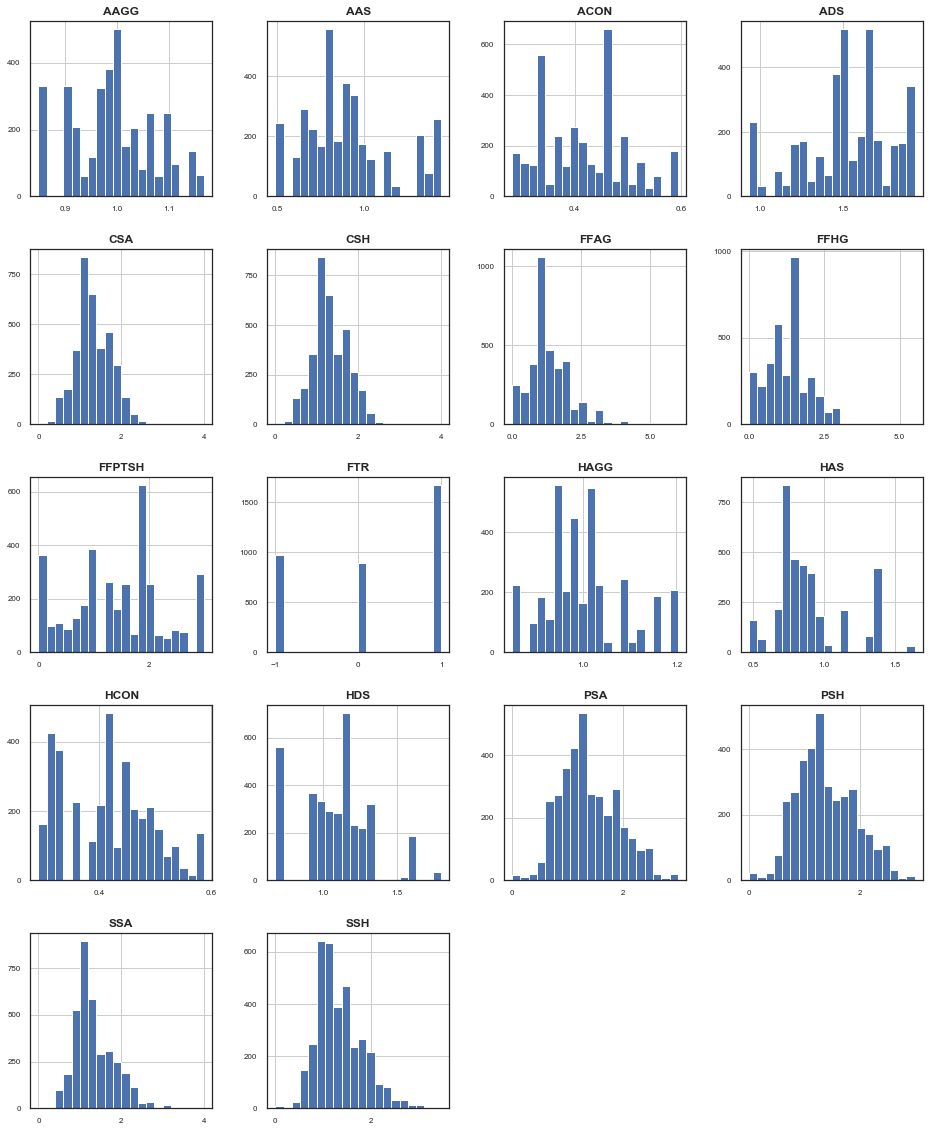

In [51]:
data_for_cor = X.copy() #Mike: not mass up with the X referencing object
data_for_cor['FTR'] = y

data_for_cor.hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8)
sns.set_style("white")

#### Correlation plot for Engineered Features

Similar to the correlation matrix plot for the raw column data, this plot visualizes the correlation between the engineered featuers, the competing teams and the full time result. This is represented on a heatmap.

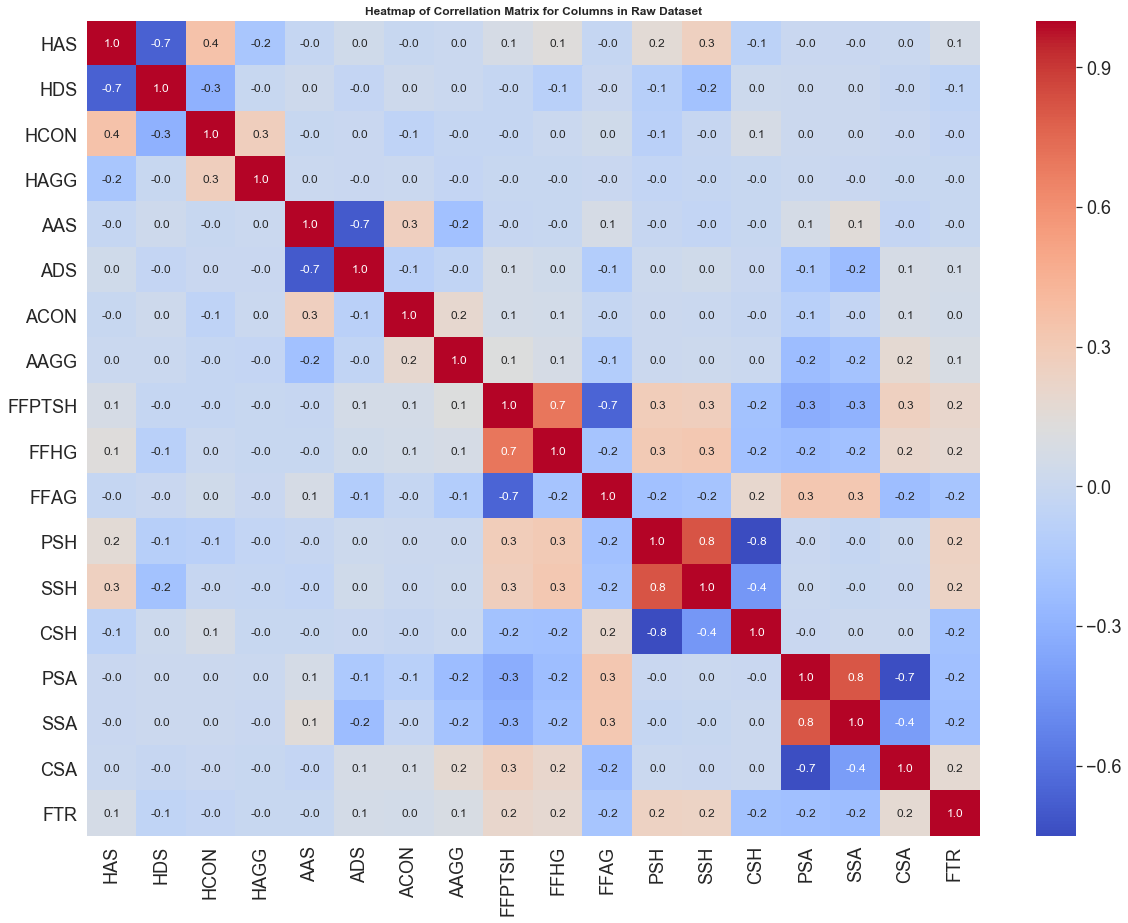

In [52]:
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
ax.set_title("Heatmap of Correllation Matrix for Columns in Raw Dataset")
sns.heatmap(data_for_cor.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax);

### Scaling the features

In [53]:
# Mike: remove Teams instead of encoding, since look-up will be performed for end predictions
X_noHA = X[[column for column in X.columns if column not in ['HomeTeam', 'AwayTeam']]] 

scaler = MinMaxScaler() #Mike: popular opts: {StandardScaler, MinMaxScaler, RobustScaler, Normalizer}
X_scaled = pd.DataFrame(scaler.fit_transform(X_noHA), columns = X_noHA.columns)

X_scaled


,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,0.754911,0.025232,0.599713,0.303188,0.688586,0.551143,0.178180,0.468885,0.642038,0.282418,0.185420,0.642038,0.448067,0.278130,0.642038,0.388325,0.278130
1,0.247612,0.421597,0.545874,0.478434,0.012618,0.921234,0.158761,0.495162,0.642038,0.282418,0.185420,0.642038,0.448067,0.278130,0.642038,0.388325,0.278130
2,0.198669,0.224161,0.688823,0.361081,0.976896,0.009548,0.460805,0.252874,0.642038,0.282418,0.185420,0.642038,0.448067,0.278130,0.642038,0.388325,0.278130
3,0.255566,0.393283,0.789535,0.957757,0.565158,0.424058,0.100190,0.683442,0.642038,0.282418,0.185420,0.642038,0.448067,0.278130,0.642038,0.388325,0.278130
4,0.491506,1.000000,0.878331,0.568522,0.275649,0.732194,0.352584,0.753788,0.642038,0.282418,0.185420,0.642038,0.448067,0.278130,0.642038,0.388325,0.278130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,0.355001,0.274688,0.146309,0.765787,0.313921,0.768625,0.256664,0.248495,0.266667,0.109091,0.300000,0.377778,0.403846,0.383333,0.533333,0.383333,0.366667
3542,0.558894,0.212335,0.508834,0.465303,0.024516,0.557609,0.295137,1.000000,0.800000,0.363636,0.066667,0.822222,0.653846,0.150000,0.555556,0.366667,0.283333
3543,0.275611,0.839827,0.075771,0.154747,0.898161,0.203770,0.550685,0.410589,0.666667,0.363636,0.166667,0.622222,0.403846,0.300000,0.266667,0.216667,0.466667
3544,0.304964,0.272384,0.310167,0.682666,0.458989,0.666815,0.650521,0.620353,0.555556,0.242424,0.111111,0.422222,0.384615,0.400000,0.111111,0.133333,0.600000


### Splitting into training and testing datasets

Splitting the full list of input features into training and testing datasets. The output labels are also split accordingly. The decided splitting ratio is 1:4 (test:train).

In [54]:
size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = size, random_state=42)

print([_.shape for _ in [X_train, X_test, y_train, y_test]])
X_train

[(2836, 17), (710, 17), (2836, 1), (710, 1)]


,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
1149,0.764481,0.041587,0.548219,0.259651,0.452235,0.370833,0.228169,0.605599,0.333333,0.181818,0.166667,0.222222,0.365385,0.516667,0.222222,0.283333,0.500000
195,0.491506,1.000000,0.878331,0.568522,0.976896,0.009548,0.460805,0.252874,0.333333,0.181818,0.166667,0.333333,0.211538,0.350000,0.311111,0.283333,0.400000
532,0.198669,0.224161,0.688823,0.361081,0.159352,0.738660,0.000000,0.011132,0.111111,0.060606,0.277778,0.466667,0.442308,0.383333,0.800000,0.683333,0.150000
2486,0.226880,0.524123,0.423561,0.862427,0.329672,0.498733,0.405104,0.483510,0.642038,0.282418,0.185420,0.666667,0.480769,0.166667,0.555556,0.366667,0.316667
2166,0.355001,0.274688,0.146309,0.765787,0.458067,0.881910,0.174355,0.000000,0.000000,0.000000,0.333333,0.066667,0.230769,0.466667,0.377778,0.250000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.336475,0.449405,1.000000,1.000000,0.330707,1.000000,0.588925,0.349297,0.333333,0.000000,0.000000,0.422222,0.384615,0.300000,0.466667,0.283333,0.200000
1294,0.230511,0.441821,0.051177,0.519240,0.330707,1.000000,0.588925,0.349297,0.166667,0.000000,0.166667,0.200000,0.173077,0.383333,0.444444,0.400000,0.366667
860,0.385855,0.786436,0.918927,0.685796,0.275649,0.732194,0.352584,0.753788,0.642038,0.282418,0.185420,0.333333,0.423077,0.450000,0.577778,0.383333,0.333333
3507,0.751846,0.000000,0.631109,0.476486,0.275649,0.732194,0.352584,0.753788,0.666667,0.363636,0.200000,0.800000,0.653846,0.200000,0.600000,0.433333,0.250000


# Model Training

#### Functions to train the classifiers

In [55]:
def get_scores(model,X,y):
    '''
    Parameters:
        model
        X
        y
    
    Returns:
    '''
    scores = cross_validate(model, X, y, scoring=('accuracy','f1_macro','precision_macro','recall_macro','roc_auc_ovr'),
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    print('Accuracy: %f'%(scores['test_accuracy'].mean()))
    print('Precision: %f'%(scores['test_precision_macro'].mean()))
    print('Recall: %f'%(scores['test_recall_macro'].mean()))
    print('f1 Score: %f'%(scores['test_f1_macro'].mean()))
    print('ROC-AUC: %f'%(scores['test_roc_auc_ovr'].mean()))
    return scores

In [56]:
def get_best_params_RandomizedCV(model,param_grid,X,y,refit='accuracy'):
    '''
    This function executes the RandomizedSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
        model
        X
        y
        param_grid
        refit='accuracy'
    
    Returns:
        grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit, random_state = 42) #M: added random state to help tracking
    grid_results.fit(X, y)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best parameters: \n',grid_results.best_params_)
    return grid_results.best_params_

In [57]:
def get_best_params_GridCV(model,param_grid,X,y,refit='accuracy'):
    '''
    This function executes the GridSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
    model
    X
    y
    param_grid
    refit='accuracy'
    
    Returns:
    grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = GridSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best parameters: \n',grid_results.best_params_)
    return grid_results.best_params_

In [58]:
# def RSC_Wrapper(model,params, x, y):
#     grid = RandomizedSearchCV(model, params, refit='accuracy')
#     grid.fit(x, y)
#     print('Mean Accuracy is',grid.best_score_)
#     return grid.best_params_

# def Grid_Wrapper(model,params, x, y):
#     grid = GridSearchCV(model, params, refit='accuracy')
#     grid.fit(x, y)
#     print('Mean Accuracy is',grid.best_score_)
#     return grid.best_params_

In [59]:
def get_model_accuracy_on_test(model,X_train,y_train,X_test,y_test,title, illust = True):    
    scores = {}
    
    classifier=model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    scores['accuracy'] = (accuracy_score(y_test, y_pred))
    scores['precision'] = (precision_score(y_test, y_pred,average='macro'))
    scores['recall'] = (recall_score(y_test, y_pred,average='macro'))
    
    if illust == True: #M: can be turned on and off now
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=['A','D','H'],
                                     cmap=plt.cm.Blues)
        disp.ax_.set_title('Confusion Matrix: %s'%(title))
        disp.confusion_matrix

    return scores

### Dictionaries for Models and Available Parameters

In [60]:
'''
Please consider adding more worth testing options or models for below
'''
# models dictionary
models_dict = {
    'knc':KNeighborsClassifier,
    'gb':GaussianNB,
    'sgd': SGDClassifier,
    'qda': QuadraticDiscriminantAnalysis,
    'dt': DecisionTreeClassifier,
    'lr': LogisticRegression,
    'mlp': MLPClassifier,
    'rfc': RandomForestClassifier,
    'svc': SVC,
}


# params_grid dictionary
pg_dict = {
    'knc':{
        'n_neighbors': range(1,10),
        'weights': ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree','brute']
    },

    'gb':{
        'priors': [None],
        'var_smoothing': uniform(0.01, 0.199)
    },

    # Regression loss options not included for sgd:
    # ['squared_loss','hinge', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
    # To test them, consider CalibratedClassifierCV() instead
    'sgd':{
        'max_iter': [1000000], # not suggest to change it! 
        'tol': [1e-3],         # not suggest to change it! 
        'loss': ['log', 'modified_huber', 'log','modified_huber'] + \
        [] #For regression loss
    },

    'qda':{},

    'dt':{
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None],
        'max_features':['sqrt','log2','auto', None]
    },
    
    'lr':{
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'C' : np.random.rand(100),
        'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
        'fit_intercept' : [True, False]
    },
    
    'mlp':{
        'activation':['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'alpha' : uniform(1e-5, 1e-4),
        'batch_size' : ['auto'],
        'learning_rate':['constant', 'invscaling', 'adaptive'],
    },
    
    'rfc':{
        'n_estimators': range(4,200),
        'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
        'min_samples_split': uniform(0.01, 0.199)
    },
    
    'svc':{
        'kernel':['linear', 'rbf', 'sigmoid',],
        'degree':range(2,5),
        'gamma':['scale', 'auto'],
        'shrinking': [True, False],
        'probability': [True], #M: it has to be True, False will trigger error for the algorithm
        'decision_function_shape': ['ovo', 'ovr'],
    }
}

print(X_train.shape)
X_train.head()

(2836, 17)


,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
1149,0.764481,0.041587,0.548219,0.259651,0.452235,0.370833,0.228169,0.605599,0.333333,0.181818,0.166667,0.222222,0.365385,0.516667,0.222222,0.283333,0.500000
195,0.491506,1.000000,0.878331,0.568522,0.976896,0.009548,0.460805,0.252874,0.333333,0.181818,0.166667,0.333333,0.211538,0.350000,0.311111,0.283333,0.400000
532,0.198669,0.224161,0.688823,0.361081,0.159352,0.738660,0.000000,0.011132,0.111111,0.060606,0.277778,0.466667,0.442308,0.383333,0.800000,0.683333,0.150000
2486,0.226880,0.524123,0.423561,0.862427,0.329672,0.498733,0.405104,0.483510,0.642038,0.282418,0.185420,0.666667,0.480769,0.166667,0.555556,0.366667,0.316667
2166,0.355001,0.274688,0.146309,0.765787,0.458067,0.881910,0.174355,0.000000,0.000000,0.000000,0.333333,0.066667,0.230769,0.466667,0.377778,0.250000,0.300000


### Tune Parameters for each Model

In [61]:
X_train

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
1149,0.764481,0.041587,0.548219,0.259651,0.452235,0.370833,0.228169,0.605599,0.333333,0.181818,0.166667,0.222222,0.365385,0.516667,0.222222,0.283333,0.500000
195,0.491506,1.000000,0.878331,0.568522,0.976896,0.009548,0.460805,0.252874,0.333333,0.181818,0.166667,0.333333,0.211538,0.350000,0.311111,0.283333,0.400000
532,0.198669,0.224161,0.688823,0.361081,0.159352,0.738660,0.000000,0.011132,0.111111,0.060606,0.277778,0.466667,0.442308,0.383333,0.800000,0.683333,0.150000
2486,0.226880,0.524123,0.423561,0.862427,0.329672,0.498733,0.405104,0.483510,0.642038,0.282418,0.185420,0.666667,0.480769,0.166667,0.555556,0.366667,0.316667
2166,0.355001,0.274688,0.146309,0.765787,0.458067,0.881910,0.174355,0.000000,0.000000,0.000000,0.333333,0.066667,0.230769,0.466667,0.377778,0.250000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.336475,0.449405,1.000000,1.000000,0.330707,1.000000,0.588925,0.349297,0.333333,0.000000,0.000000,0.422222,0.384615,0.300000,0.466667,0.283333,0.200000
1294,0.230511,0.441821,0.051177,0.519240,0.330707,1.000000,0.588925,0.349297,0.166667,0.000000,0.166667,0.200000,0.173077,0.383333,0.444444,0.400000,0.366667
860,0.385855,0.786436,0.918927,0.685796,0.275649,0.732194,0.352584,0.753788,0.642038,0.282418,0.185420,0.333333,0.423077,0.450000,0.577778,0.383333,0.333333
3507,0.751846,0.000000,0.631109,0.476486,0.275649,0.732194,0.352584,0.753788,0.666667,0.363636,0.200000,0.800000,0.653846,0.200000,0.600000,0.433333,0.250000


In [62]:
# Mike: get best params list for models
def get_model_bp_records(gbp_func, models_dict, pg_dict, *args, **kwargs):
    model_bp_records = [] #M: tuple pairs of model name, bp
    for m in models_dict:
        print('Searching for Model:', m)
        model_bp_records.append((m, gbp_func(models_dict[m](), pg_dict[m], *args, **kwargs)))
        print('\n')
    
    return model_bp_records

records = get_model_bp_records(get_best_params_RandomizedCV, 
                                  models_dict, pg_dict, X_train, y_train, refit='accuracy')

Searching for Model: knc
Best mean accuracy Score:  0.4703777434927586
Best mean f1_macro Score:  0.4075208524601244
Best mean roc_auc_ovr Score:  0.4075208524601244
Best parameters: 
 {'weights': 'distance', 'n_neighbors': 9, 'algorithm': 'brute'}


Searching for Model: gb
Best mean accuracy Score:  0.5000111979296272
Best mean f1_macro Score:  0.40887472683306525
Best mean roc_auc_ovr Score:  0.40887472683306525
Best parameters: 
 {'priors': None, 'var_smoothing': 0.1823690530092121}


Searching for Model: sgd
Best mean accuracy Score:  0.49504927089035977
Best mean f1_macro Score:  0.3579855230424987
Best mean roc_auc_ovr Score:  0.3579855230424987
Best parameters: 
 {'tol': 0.001, 'max_iter': 1000000, 'loss': 'log'}


Searching for Model: qda
Best mean accuracy Score:  0.4848330264271139
Best mean f1_macro Score:  0.40866809628559275
Best mean roc_auc_ovr Score:  0.40866809628559275
Best parameters: 
 {}


Searching for Model: dt
Best mean accuracy Score:  0.42345966256905393
Best 

In [63]:
# # Get tuned parameters for models
# def get_parameters(gbp_func, models, params, *args):
#     model_bp_records = [] #M: tuple pairs of model name, bp
#     for m in models_dict:
#         print('Searching for Model:', m)
#         model_bp_records.append((m, gbp_func(models_dict[m](), pg_dict[m], *args)))
#         print('\n')
    
#     return model_bp_records

# records_RSC = get_parameters(RSC_Wrapper, models_dict, pg_dict, X_train, y_train)
# # records_Grid = get_parameters(RSC_Wrapper, models_dict, pg_dict, X_train, y_train)

In [64]:
# #M: TESTING, NO NEED TO RUN IT IF GRAPHS ARE USED FOR COMPARISONS, SINCE IT TAKES QUITE SOME TIME
# def models_mean_scores_byCV(CVfunc, model_dict,pg_dict,X,y,refit='accuracy'):
#     scoring=('accuracy','f1_macro','roc_auc_ovr')
#     other_scores=[score for score in list(scoring) if score!=refit]
    
#     models, acc, f1, rao = [], [], [], []
#     print('Now Searching for Scores, Please Wait.')
#     for m in models_dict:
# #         print('Searching for Model:', m)
        
#         grid_results = CVfunc(models_dict[m](), pg_dict[m], 
#                                            cv=10,n_jobs=n_cpu,
#                                            scoring=scoring,
#                                            refit=refit)
#         grid_results.fit(X, y)
#         cv_results=grid_results.cv_results_
#         best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
        
#         models.append(m)
#         acc.append(grid_results.best_score_)
#         f1.append(cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
#         rao.append(cv_results['mean_test_%s'%(other_scores[1])][best_index_results])
        
#     idx = [acc,f1,rao]
#     return pd.DataFrame(idx, index = ['mean accuracy','mean f1-score', 'mean roc_auc_ovr score'], columns = models)

# models_mean_scores_byCV(RandomizedSearchCV, models_dict, pg_dict, X_train, y_train ,refit='accuracy', )

since now we have different models with tuned parameters, we create instances for each of them, and to be ready for testing.

In [65]:
from collections import OrderedDict

#Mike: Create Ordered Dict of (model name, model instance with tuned params) pairs
models_best_dict = OrderedDict({m_name:models_dict[m_name](**params) for m_name, params in records})

### Scores of the tuned models on test dataset

Let's see how good these tuned models perform on our splitted test set, and in comparison to the train set.

In [66]:
# TODO: consider use a pd dataframe for better viewing
def get_scores_all(models, X_train, y_train, X_test, y_test):
    scores_lst = []
    for model in models:
        print("%s" %type(model).__name__) #M: not a good pratice to use __name__ but it is convienient.
        
        ret = get_model_accuracy_on_test(model, X_train, y_train, X_test, y_test, title = 'Hiworld', illust = False)
        print(ret)
        scores_lst.append(ret)
        
        print("\n")
    return scores_lst

models_best = models_best_dict.values()

print('Testing on Test Set')
print('='*100)
scores_all_testset = get_scores_all(models_best, X_train, y_train, X_test, y_test)

print('Testing on Train Set')
print('='*100)
scores_all_testset = get_scores_all(models_best, X_train, y_train, X_train, y_train)

Testing on Test Set
KNeighborsClassifier
{'accuracy': 0.48732394366197185, 'precision': 0.4363707572664506, 'recall': 0.4284782031143199}


GaussianNB
{'accuracy': 0.5422535211267606, 'precision': 0.4744335511982571, 'recall': 0.4668320036730093}


SGDClassifier
{'accuracy': 0.5492957746478874, 'precision': 0.35542007593988983, 'recall': 0.4650162511434188}


QuadraticDiscriminantAnalysis
{'accuracy': 0.523943661971831, 'precision': 0.4615433113017217, 'recall': 0.454855212289574}


DecisionTreeClassifier
{'accuracy': 0.4422535211267606, 'precision': 0.40489963923054423, 'recall': 0.4052156544669951}


LogisticRegression
{'accuracy': 0.5492957746478874, 'precision': 0.46900902822208, 'recall': 0.4443865260774516}


MLPClassifier
{'accuracy': 0.5464788732394367, 'precision': 0.44592936209901085, 'recall': 0.44591819722399845}


RandomForestClassifier
{'accuracy': 0.532394366197183, 'precision': 0.3586072600793612, 'recall': 0.4210505829002939}


SVC
{'accuracy': 0.5408450704225352, 'pre

We can observe that testing on test set generally has a decrese of 1~5% accuracy, as well as other scores.

However, the results so far are still not bad, considering we can get the betting at most about 50% right out of 3 classes.

### Visualize Each Model's Performance on Test Set

In [67]:
# # TODO: consider ploting both performances together for comparison
# socres_all = scores_all_testset
# x = list(models_dict.keys())
# y_pos = np.arange(len(x))

# scores_types = {'Accuracy':'test_accuracy',
#                 'Precision':'test_precision_macro',
#                 'Recall':'test_recall_macro',
#                 'f1 Score':'test_f1_macro',
#                 'ROC-AUC': 'test_roc_auc_ovr',
#                }

# scores_all = scores_all_testset
# y_vals_lst = [[scores[vals].mean() for scores in scores_all] for vals in scores_types.values()]

# fig = plt.figure()
# for typ, num in zip(scores_types.keys(), range(1, len(scores_types) + 1)):
#     y_vals = y_vals_lst[num-1]
#     ax = fig.add_subplot(5,3,num)
#     ax.bar(y_pos, y_vals, align='center', alpha=0.7, width = 0.5)
    
#     fig.set_figheight(20)
#     fig.set_figwidth(15)

#     ax.set_title(typ)
#     plt.ylim([0.2,0.7])
    
#     plt.xticks(y_pos, x)
#     plt.ylabel('score')

# plt.tight_layout()
# plt.show()

So far, we haven't tested the models on novel inputs. Recall the test set was splitted from the whole data set with the engineered features. However, the novel inputs don't have these well engineered features, they have two team names only: the Home team and the Away team.

From the very previous section, I briefly talked about our current solution: perform a lookup for the recent matchups' performance, and assume the performance has relationship with the novel inputs. Let's test how good it can work.

### Novel Inputs Testing Emulation

As described in the previous section, let's save some copies of (HomeTeam, AwayTeam) inputs and (Ftr) outputs pair to test how well the lookup perform for emulation

In [68]:
X_c1 = X.copy() #Mike: savepoint

In [69]:
X = X_c1.copy()

_, X_novel, _, y_novel = train_test_split(X, y, test_size = size, random_state=42)
X_novel = X_novel[['HomeTeam', 'AwayTeam']]

# The X_novel, y_novel pairs before X_novel lookups
# pd.concat([X_novel, y_novel], axis = 1)
y

,FTR
0,1
1,1
2,-1
3,1
4,1
...,...
3541,0
3542,1
3543,-1
3544,0


### By now, let's implement a look-up for teams' abilities

Let consider the lateast few match-ups of individual team's ability value against each other, since we are more interested in quantifying how good they perform against each other, instead of the team name. 

These ability values are also the ones we will be using to classify during trainning.

In [70]:
X_c2 = X.copy() #Mike: savepoint

In [71]:
X = X_c2.copy()

Implement a simple lookup function. The example demostrate how it works out the expected ability values of the recent 3 matchups.

In [72]:
#Mike: it takes the recent 3 matchups abi data for H vs A and work out the mean.
# Assume Each Team Has At Least 3 Matchups Against Each Other !
def lookup_simple(X, HomeTeam, AwayTeam):
    return X.loc[X['HomeTeam'] == HomeTeam].loc[X['AwayTeam'] == AwayTeam].tail(3).mean(axis=0)

pd.DataFrame(lookup_simple(X, 'Arsenal', 'West Brom')).transpose()

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,1.3538,0.703678,0.469045,0.955754,1.146046,1.483118,0.338252,0.998731,2.066667,1.733333,0.866667,1.844444,1.866667,1.155556,0.933333,0.933333,1.311111


Let's use the newly acquired function to lookup for the emulated novel teamname inputs.

In [73]:
#Mike: slow O(m*n) performance, consider to optimise lookup_simple implementation when have time
def TeamNames_to_Abilities(X_TeamName):
    X_Abi = pd.DataFrame()
    
    for _, row in X_TeamName.iterrows():
        abi_series = lookup_simple(X, row['HomeTeam'], row['AwayTeam'])
        X_Abi = X_Abi.append(abi_series, ignore_index = True)

    X_Abi = X_Abi[abi_series.keys()] #Mike: Re-arrange the order of columns to follow the original format
    return X_Abi

X_lookup = TeamNames_to_Abilities(X_novel)
X_lookup

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,1.353800,0.703678,0.469045,0.955754,0.789242,1.699063,0.362652,0.928338,0.800000,0.933333,1.266667,1.844444,1.933333,1.111111,1.933333,1.688889,0.822222
1,0.778314,1.194007,0.415584,0.945297,0.805228,1.928802,0.465950,0.960534,0.000000,0.166667,1.166667,1.155556,0.933333,1.311111,1.377778,1.133333,1.222222
2,0.794009,1.617947,0.314516,0.902987,0.502304,1.850593,0.332215,1.007124,1.333333,1.400000,1.333333,1.800000,1.377778,0.866667,1.133333,1.044444,1.866667
3,0.737094,1.263614,0.417092,1.154553,0.789242,1.699063,0.362652,0.928338,1.266667,1.533333,1.533333,2.155556,1.911111,0.755556,2.311111,2.111111,0.800000
4,0.781746,1.155676,0.529915,0.856242,0.819548,1.639096,0.593750,0.975403,1.233333,1.411111,1.394444,1.111111,0.955556,1.377778,1.533333,1.466667,1.155556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,0.718650,1.191511,0.408133,0.946084,0.752795,1.662890,0.392473,1.089729,0.200000,1.000000,2.466667,1.044444,0.977778,1.755556,1.888889,1.777778,0.911111
706,0.737094,1.263614,0.417092,1.154553,1.371670,1.127471,0.448554,0.965242,1.244444,0.933333,0.444444,2.022222,1.711111,1.000000,1.000000,1.022222,1.800000
707,0.718650,1.191511,0.408133,0.946084,0.876247,1.486792,0.421990,0.973923,2.086482,0.962211,0.481951,1.044444,0.888889,1.377778,1.177778,1.177778,1.511111
708,1.350221,0.675359,0.478305,1.017359,1.028502,1.356932,0.314005,1.067260,2.000000,2.066667,1.266667,2.266667,2.177778,0.688889,1.133333,1.400000,1.666667


The above X_lookup is exactly what we want. 

To explicitly see the mapping of lookup, please see below

In [74]:
X_novel_reset = X_novel.reset_index().drop(columns = 'index')

print('Rows and Columns of novel X: %d and %d\nRows and Columns of lookup X: %d and %d' 
      %(*X_novel_reset.shape, *X_lookup.shape))

#Mike: show the mapping
pd.concat([X_novel_reset, X_lookup], axis = 1)

Rows and Columns of novel X: 710 and 2
Rows and Columns of lookup X: 710 and 17


,HomeTeam,AwayTeam,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,Arsenal,Chelsea,1.353800,0.703678,0.469045,0.955754,0.789242,1.699063,0.362652,0.928338,0.800000,0.933333,1.266667,1.844444,1.933333,1.111111,1.933333,1.688889,0.822222
1,Burnley,Swansea,0.778314,1.194007,0.415584,0.945297,0.805228,1.928802,0.465950,0.960534,0.000000,0.166667,1.166667,1.155556,0.933333,1.311111,1.377778,1.133333,1.222222
2,Man United,Stoke,0.794009,1.617947,0.314516,0.902987,0.502304,1.850593,0.332215,1.007124,1.333333,1.400000,1.333333,1.800000,1.377778,0.866667,1.133333,1.044444,1.866667
3,Tottenham,Chelsea,0.737094,1.263614,0.417092,1.154553,0.789242,1.699063,0.362652,0.928338,1.266667,1.533333,1.533333,2.155556,1.911111,0.755556,2.311111,2.111111,0.800000
4,Norwich,Everton,0.781746,1.155676,0.529915,0.856242,0.819548,1.639096,0.593750,0.975403,1.233333,1.411111,1.394444,1.111111,0.955556,1.377778,1.533333,1.466667,1.155556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Swansea,Tottenham,0.718650,1.191511,0.408133,0.946084,0.752795,1.662890,0.392473,1.089729,0.200000,1.000000,2.466667,1.044444,0.977778,1.755556,1.888889,1.777778,0.911111
706,Tottenham,Wigan,0.737094,1.263614,0.417092,1.154553,1.371670,1.127471,0.448554,0.965242,1.244444,0.933333,0.444444,2.022222,1.711111,1.000000,1.000000,1.022222,1.800000
707,Swansea,Watford,0.718650,1.191511,0.408133,0.946084,0.876247,1.486792,0.421990,0.973923,2.086482,0.962211,0.481951,1.044444,0.888889,1.377778,1.177778,1.177778,1.511111
708,Man City,Fulham,1.350221,0.675359,0.478305,1.017359,1.028502,1.356932,0.314005,1.067260,2.000000,2.066667,1.266667,2.266667,2.177778,0.688889,1.133333,1.400000,1.666667


The above explictily demostrates how it works. Now use the previous tuned training models, and see how good this does.

In [75]:
print('Testing on Novel set')
print('='*100)

for key in models_best_dict.keys():
    model_tuned = models_best_dict[key]
    s = get_model_accuracy_on_test(model_tuned, X_train, y_train, X_lookup, y_novel, title = 'Hiworld', illust = False)
    print(key, s, '\n')

# print(models_best_dict.keys())

Testing on Novel set
knc {'accuracy': 0.5126760563380282, 'precision': 0.4373850512652866, 'recall': 0.42003736320889323} 

gb {'accuracy': 0.5647887323943662, 'precision': 0.36399475114291896, 'recall': 0.47705377474163607} 

sgd {'accuracy': 0.5126760563380282, 'precision': 0.564163899326738, 'recall': 0.4314669784410017} 

qda {'accuracy': 0.3211267605633803, 'precision': 0.5358454394322401, 'recall': 0.38657297491478143} 

dt {'accuracy': 0.252112676056338, 'precision': 0.3234484484484485, 'recall': 0.33613111874132834} 

lr {'accuracy': 0.5070422535211268, 'precision': 0.5224011969048789, 'recall': 0.4902726454366541} 

mlp {'accuracy': 0.5028169014084507, 'precision': 0.524574039396205, 'recall': 0.4587604812899053} 

rfc {'accuracy': 0.2859154929577465, 'precision': 0.31401648998822146, 'recall': 0.341564658822128} 

svc {'accuracy': 0.48732394366197185, 'precision': 0.1624413145539906, 'recall': 0.3333333333333333} 



### Observation of Interests

Surprisingly, some models, such as RandomForestClassifier continues to work well in the novel inputs prediction. Whereas some models, such as MLPClassifier, fails to consistently works as well as what it does on training set and test set.

This can be caused by:
1)The implementation of lookup.
2)The way it classifies(ie. the Maths) does not fit this approach well
3)Underfitting or overfitting during the parameters tuning

It's an interesting finding, and may have suggested the things we can try to improve for our model performance, it can be worth some more time to further investigate depending on the time availability.

### Summary of the Models' Results

From the verbal massages, we can see the models with accuracy around 53%, which is the possibly treshold that can not be easily passed suggested by the introduction of this assignment, are Logistic Regression, Multilayer Perceptron Classifier and Gaussian Naive Baysian. 

These outcomes were not bad in my personal thoughts, considering the possibly many additional improvements we could still try to improve our data engineering, models' parameters or even the simple lookup method. However, from now I may move to have a look what can be solved when using these models for final predictions first.

Among the models, I prefer Gaussian Naive Baysian the most. Though it does not provide the best accuracy (it is 1% off the most accurate one), but it has a very good f1 score of about 0.49. 

From the machine learning lecture, I learned that there can be underfitting or overfitting of our train models, accuracy should not be the only consideration for the model selection, recall and precision are important as well. 

In brief, while recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.
However, there are trade-off between precision and recall, better precision means wrose recall, and vice versa. f1-score is the quantity helping to find a balance between them.

# Final Prediction

### Import Novel Test Data

First of all, we import the test data to be predicted

In [76]:
# Select only HomeTeam and AwayTeam columns from the data set
data_test=pd.read_csv('Data/epl-test.csv')
data_test.dropna(axis=1, how='all',inplace=True)

data_test

,Date,HomeTeam,AwayTeam
0,11 Jan 20,Bournemouth,Watford
1,11 Jan 20,Aston Villa,Man City
2,11 Jan 20,Chelsea,Burnley
3,11 Jan 20,Crystal Palace,Arsenal
4,11 Jan 20,Everton,Brighton
5,11 Jan 20,Leicester,Southampton
6,11 Jan 20,Man United,Norwich
7,11 Jan 20,Sheffield United,West Ham
8,11 Jan 20,Tottenham,Liverpool
9,11 Jan 20,Wolves,Newcastle


We now transform these teamname texts to some useful data that we have been engineering and training for.

In [77]:
#Mike: Remove date. In case season or date related is implemented, change this
data_test_date = pd.DataFrame(data_test['Date'], columns = ['Date'])
data_test_dropdate = data_test.drop(['Date'], axis = 1) 

data_test_lookup = TeamNames_to_Abilities(data_test_dropdate)

data_test_lookup

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,0.821861,1.172980,0.422527,1.022211,0.876247,1.486792,0.421990,0.973923,1.308705,1.267766,1.120840,0.933333,1.133333,1.666667,1.111111,0.911111,1.377778
1,0.741335,1.171241,0.307263,1.032557,1.321852,0.935871,0.457184,0.990735,0.600000,0.666667,2.400000,1.044444,1.088889,1.688889,2.266667,2.244444,0.888889
2,0.720433,1.037968,0.362162,0.983217,0.699113,1.911859,0.413902,1.001459,2.508705,2.151100,0.737507,2.044444,1.688889,1.066667,1.533333,0.911111,1.000000
3,0.858388,1.090923,0.405667,0.892257,1.442614,1.220673,0.457733,0.897636,0.600000,1.066667,1.733333,1.111111,0.955556,1.333333,1.866667,2.022222,1.133333
4,0.704146,0.926949,0.495327,0.976335,0.921615,1.536025,0.542857,1.039814,1.000000,1.000000,1.000000,1.400000,1.266667,1.333333,1.266667,0.933333,1.400000
5,0.886731,0.983657,0.335320,1.120200,0.676852,1.499904,0.382253,1.071998,1.561111,1.194444,1.111111,1.933333,1.600000,1.000000,1.244444,1.333333,1.400000
6,0.794009,1.617947,0.314516,0.902987,0.946168,1.892335,0.494737,0.898745,2.266667,1.777778,0.488889,2.066667,1.711111,0.822222,0.911111,0.888889,1.488889
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.737094,1.263614,0.417092,1.154553,0.999291,1.235304,0.459123,1.027783,0.733333,1.000000,1.666667,2.266667,2.022222,0.733333,1.977778,2.088889,0.955556
9,0.554375,1.023701,0.415816,1.033033,0.699113,1.433895,0.493355,0.982200,0.975371,1.267766,1.954174,1.266667,1.200000,1.377778,1.088889,1.066667,1.377778


However, by noticing the above table row 7, the lookup fails to return values.

### Investigation on Missing Lookup Outputs

Let's see what the 2 teams are corresponding to this row.

In [78]:
data_test[['HomeTeam', 'AwayTeam']].iloc[[7]]

,HomeTeam,AwayTeam
7,Sheffield United,West Ham


Let's see if any of the team does not exist in our training data

In [79]:
aHT = 'Sheffield United'
aAT = 'West Ham'

print('Any team not exists?\n')
print('{} {} in training'.format(aHT, aHT not in data[['HomeTeam', 'AwayTeam']].values and 'not exists' or 'exists'))
print('{} {} in training'.format(aAT, aAT not in data[['HomeTeam', 'AwayTeam']].values and 'not exists' or 'exists'))

Any team not exists?

Sheffield United not exists in training
West Ham exists in training


### Unseen Team Handling from the Novel Test Data

Thus, the team Sheffield United never appears in our training.

Let's implement a function to handle this situation from novel inputs.

In [80]:
#Mike: 
def split_dataInTrain_dataNotInTrain(data_novel, data_train):
    HT_in_train = set(data_train['HomeTeam'].unique().tolist())
    AT_in_train = set(data_train['AwayTeam'].unique().tolist())
    teams_in_train = HT_in_train.union(AT_in_train)
    
    dataInTrain = data_novel.copy()
    dataNotInTrain = pd.DataFrame(columns = data_novel.columns)
    for idx, row in data_novel.iterrows():
        if row['HomeTeam'] not in teams_in_train \
        or row['AwayTeam'] not in teams_in_train:
            dataNotInTrain.loc[idx] = row
            dataInTrain = dataInTrain.drop(idx)
            
    return dataInTrain, dataNotInTrain

dataInTrain, dataNotInTrain = split_dataInTrain_dataNotInTrain(data_test_dropdate, data)
dataInTrain

,HomeTeam,AwayTeam
0,Bournemouth,Watford
1,Aston Villa,Man City
2,Chelsea,Burnley
3,Crystal Palace,Arsenal
4,Everton,Brighton
5,Leicester,Southampton
6,Man United,Norwich
8,Tottenham,Liverpool
9,Wolves,Newcastle


From the process, I splitted novel test data by rows into the team pairs have and haven't been seen from the training set.

The ones have been seen can be applicable to the trained model's prediction.
The ones have not been seen will need to be taken additional consideration for approach.

### Handling Unseens by Betting

In the following betting function, two policies are implemented for unseens. 1) We choose randomly from 1 of the 3 results, by assuming the results following Beernoulli Distribution, we expect this to get right at accuracy of 33.3%. 2) We choose by all betting the result with the most appreances from our training set.

The policy 2 actually could be better than the policy 1, recall that in the Data Preprocessing section, we checked about the unbalance of outcomes from H, D and A, and can be seemed that H (ie. Home Win) occupies the most number of occurrences, or it can be explicitly shown as below: 

In [81]:
from collections import Counter

c = Counter()
for result in data['FTR']:
    c[result] +=1

for key, val in c.items():
    print('Appearance of {} is {} times and it occupies {:.1f}%'.format(key, val, 100*val/(data.shape[0])))

Appearance of H is 1670 times and it occupies 47.1%
Appearance of A is 978 times and it occupies 27.6%
Appearance of D is 898 times and it occupies 25.3%


From the above overview of appearances of FTR, we can see the bias to Home Win is actually quite considerable.

I realized that it was not always a good idea nor necessary to use the Bernoulli assumption, so I implemented a policy to always choose the most present FTR. But by default, some people might still prefer Bernoulli assumption, so this policy is also provided.

In [82]:
from random import choice

def betting(data_novel, data_train, POLICY = 1):
    def choose_randomly(*args):
        return choice(['H','D','A'])
    
    def choose_bymost(data_train):
        #M: choose the result that appears the most
        return max([(val, (data_train.FTR.values == val).sum(),) for val in 'HDA'], key = lambda x: x[1])[0]
    
    bet_func = [choose_randomly, choose_bymost][POLICY]
    lst_ret = []
    for i in range(data_novel.shape[0]):
        lst_ret.append(bet_func(data_train))
        
    return lst_ret
        
    

### Prediction for Teams Seen on Training

In [83]:
# for teams all in training case
model_predict = 'lr' #M: multivariate logistic regression
model_predictions = models_best_dict[model_predict].fit(X_train, y_train).predict(TeamNames_to_Abilities(dataInTrain))

predictions_it = pd.DataFrame(model_predictions, columns = ['FTR'], index = dataInTrain.index)#M: initialize df for num predictions
predictions_it['FTR'] = predictions_it['FTR'].map(decodeHDA) #M: decode num back to HDA

predictions_it

,FTR
0,D
1,A
2,H
3,A
4,H
5,H
6,H
8,D
9,D


### Betting for Teams not Seen on Training

In [84]:
# for team not appears in training case
betting_outcomes = betting(dataNotInTrain, data)
predictions_nit = pd.DataFrame(betting_outcomes, columns = ['FTR'], index = dataNotInTrain.index)

predictions_nit

,FTR
7,H


### The Prediction and Save for CSV Submission

In [85]:
dataInTrain_predict = dataInTrain.join(predictions_it)
dataNotInTrain_predict = dataNotInTrain.join(predictions_nit)

#Mike: Do not change it, though it is not elegant. For some reason, the num index dtype for them changes during
# process, concat them altoghther will be buggy. Unless this is fixed in codes first, just left untouched.
data_predict = pd.concat([dataInTrain_predict, dataNotInTrain_predict]).sort_index()
data_predict = data_test_date.join(data_predict)

data_predict #M: it matches the submission sample format now. FINALE !

,Date,HomeTeam,AwayTeam,FTR
0,11 Jan 20,Bournemouth,Watford,D
1,11 Jan 20,Aston Villa,Man City,A
2,11 Jan 20,Chelsea,Burnley,H
3,11 Jan 20,Crystal Palace,Arsenal,A
4,11 Jan 20,Everton,Brighton,H
5,11 Jan 20,Leicester,Southampton,H
6,11 Jan 20,Man United,Norwich,H
7,11 Jan 20,Sheffield United,West Ham,H
8,11 Jan 20,Tottenham,Liverpool,D
9,11 Jan 20,Wolves,Newcastle,D


In [86]:
# print(os.getcwd())
data_predict.to_csv('./Data/epl-prediction-submisssion.csv', index = False)